In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, StandardScaler, RobustScaler, KBinsDiscretizer, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit, KFold, GridSearchCV, RepeatedKFold
from itertools import combinations
from tqdm.notebook import tqdm
from rfpimp import permutation_importances
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
import optuna
from category_encoders import CatBoostEncoder, LeaveOneOutEncoder, BinaryEncoder, JamesSteinEncoder, WOEEncoder, TargetEncoder
from scipy.stats import chi2_contingency
from feature_engine.encoding import PRatioEncoder, MeanEncoder
from sklearn.decomposition import NMF
from rfpimp import permutation_importances
from feature_engine.outliers import Winsorizer
from scipy.stats import spearmanr

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sample = pd.read_csv('SampleSubmission.csv')

ID : Unique ID

CountryCode : Country Code

region_code : Region Code

year : Year

sex : Sex

agefrom : Starting Age

ageto : Finishing Age

percentage_no_schooling : Percentage of No Schooling Attained in Pop.

percentage_primary_schooling : Percentage of Primary Schooling Attained in Pop.

percentage_primary_schooling_completed : Percentage of Complete Primary Schooling Attained in Pop.

percentage_secondary_schooling : Percentage of Secondary Schooling Attained in Pop.

percentage_secondary_schooling_completed : Percentage of Complete Secondary Schooling Attained in Pop.

percentage_tertiary_schooling : Percentage of Tertiary Schooling Attained in Pop.

percentage_tertiary_schooling_completed : Percentage of Complete Tertiary Schooling Attained in Pop.

yr_sch : Average Years of Schooling Attained

literate_pop : Literate population

target = LR : Literacy rate (in percentage)

In [3]:
train = train.drop(['ageto'], axis= 1)
test = test.drop(['ageto'], axis= 1)

In [4]:
ids = test.ID

In [5]:
df = pd.concat([train, test], axis= 0)

<AxesSubplot:>

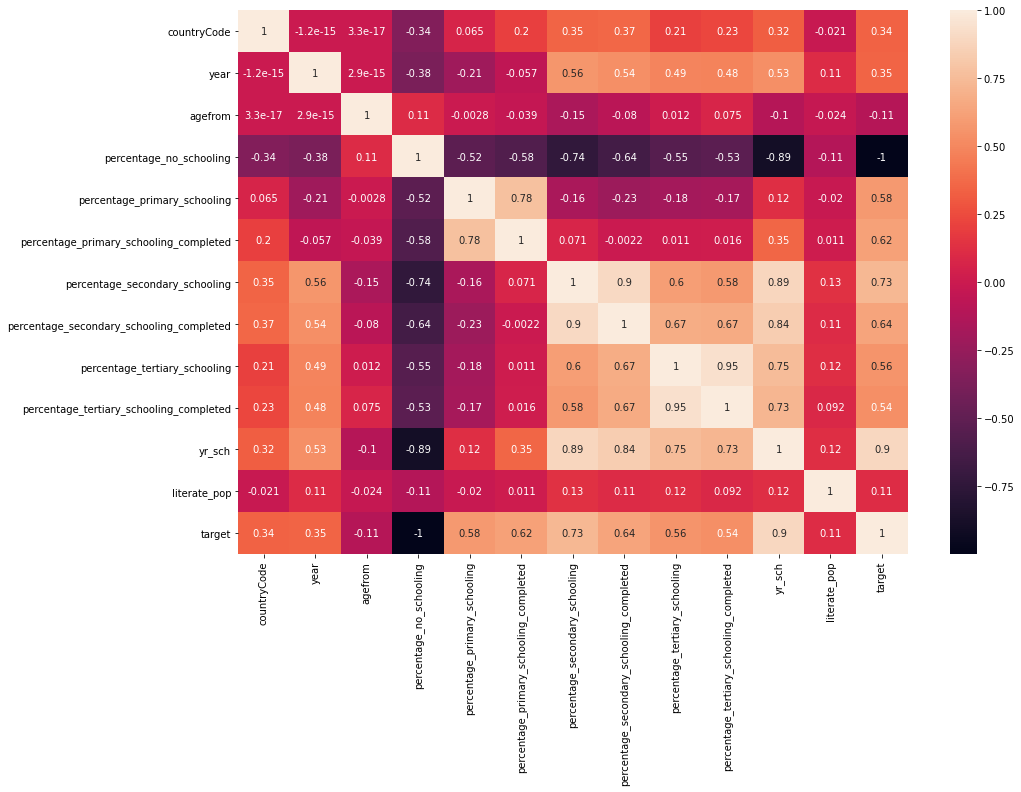

In [6]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot= True)

<AxesSubplot:>

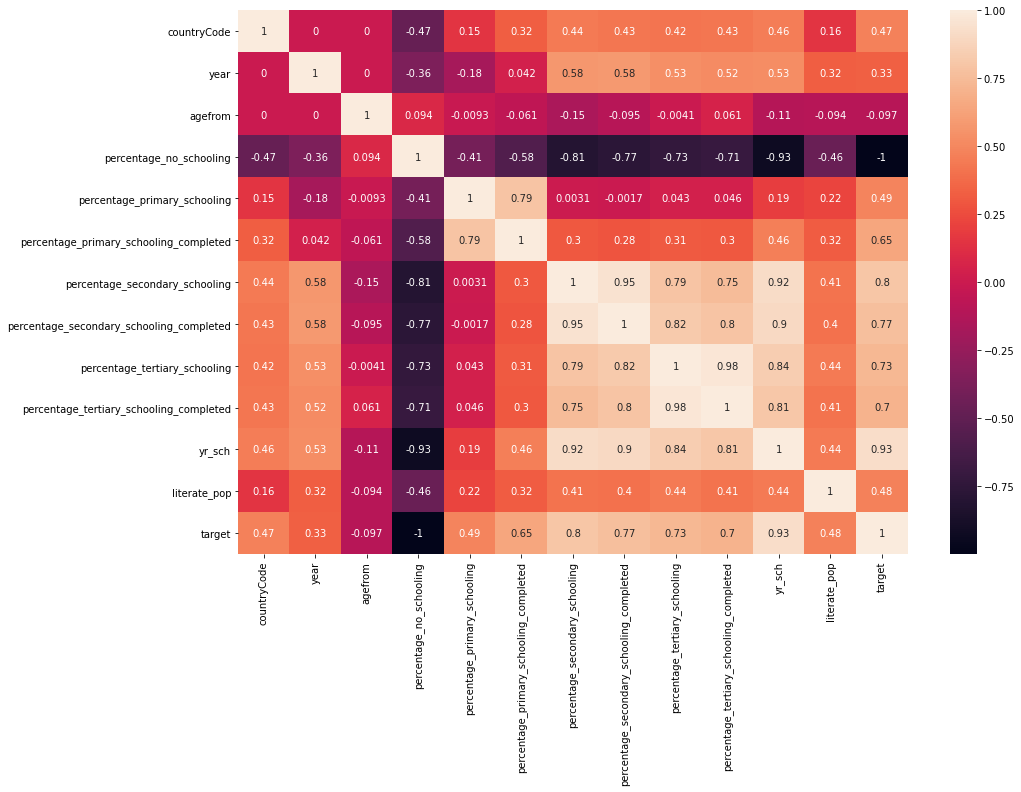

In [7]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr('spearman'), annot= True)

In [8]:
test.head()

,ID,countryCode,year,sex,agefrom,percentage_no_schooling,percentage_primary_schooling,percentage_primary_schooling_completed,percentage_secondary_schooling,percentage_secondary_schooling_completed,percentage_tertiary_schooling,percentage_tertiary_schooling_completed,yr_sch,region_code,literate_pop
0,ID_00ILO0W,69,2010,MF,25,12.37,37.01,24.83,39.32,24.62,11.30,8.01,7.66,Latin America and the Caribbean,97760.0
1,ID_00KPO3Y,56,2010,M,15,16.77,54.94,24.52,28.27,13.55,0.03,0.02,5.32,Latin America and the Caribbean,3261.0
2,ID_00MLY2L,99,2010,M,25,11.60,30.36,17.55,44.61,25.21,13.43,9.16,8.27,Middle East and North Africa,6332.0
3,ID_00PVY5K,329,2010,F,15,4.78,11.73,9.94,69.66,42.76,13.84,8.39,10.39,Europe and Central Asia,4181.0
4,ID_00TLQ4J,70,2010,M,15,2.18,15.62,7.20,67.16,39.66,15.04,6.88,9.98,Latin America and the Caribbean,6387.0


In [9]:
train.head()

,ID,countryCode,year,sex,agefrom,percentage_no_schooling,percentage_primary_schooling,percentage_primary_schooling_completed,percentage_secondary_schooling,percentage_secondary_schooling_completed,percentage_tertiary_schooling,percentage_tertiary_schooling_completed,yr_sch,region_code,literate_pop,target
0,ID_00AMK8K,155,1990,MF,15,8.3900,26.270000,15.830000,58.570000,26.420000,6.770000,4.400000,8.540000,Latin America and the Caribbean,7435.0,91.609167
1,ID_00ANS9C,115,2005,MF,25,0.6325,6.980833,6.363333,77.683333,49.995833,14.700833,13.546667,11.631667,Europe and Central Asia,14350.0,99.362969
2,ID_00AQU1S,30,2000,M,15,68.5300,26.320000,16.020000,4.620000,2.320000,0.540000,0.310000,1.550000,Sub-Saharan Africa,1458.0,31.469890
3,ID_00AVQ7Q,143,1960,MF,15,12.5300,69.370000,49.260000,8.130000,1.100000,9.970000,5.510000,7.490000,Latin America and the Caribbean,45.0,86.538462
4,ID_00BAH2C,70,1955,MF,25,20.9800,55.900000,22.380000,20.850000,10.240000,2.270000,1.950000,4.890000,Latin America and the Caribbean,2380.0,79.017264


In [10]:
win = Winsorizer(capping_method='iqr', tail='right', fold=1.5, variables=['percentage_primary_schooling_completed', 'percentage_secondary_schooling', 'percentage_secondary_schooling_completed', 'percentage_tertiary_schooling', 'percentage_tertiary_schooling_completed'])
win.fit(df)
df = win.transform(df)

In [11]:
df['took_primary'] = np.round((df.literate_pop * df.percentage_primary_schooling_completed)/100, decimals=0)
df['took_secondary'] = np.round((df.literate_pop * df.percentage_secondary_schooling_completed)/100, decimals = 0)
df['took_tertiary'] = np.round((df.literate_pop * df.percentage_tertiary_schooling_completed)/100, decimals= 0)

In [12]:
df['country_by_year'] = df.countryCode.astype(str) + '_' + df.year.astype(str)
df['country_by_sex'] = df.countryCode.astype(str) + '_' + df.sex.astype(str)
#df['country_by_agefrom'] = df.countryCode.astype(str) + '_' + df.agefrom.astype(str)
df['country_by_region'] = df.countryCode.astype(str) + '_' + df.region_code.astype(str)
df['year_by_sex'] = df.year.astype(str) + '_' + df.sex.astype(str)
#df['year_by_agefrom'] = df.year.astype(str) + '_' + df.agefrom.astype(str)
df['year_by_region'] = df.year.astype(str) + '_' + df.region_code.astype(str)
#df['sex_by_agefrom'] = df.sex.astype(str) + '_' + df.agefrom.astype(str)
df['sex_by_region'] = df.sex.astype(str) + '_' + df.region_code.astype(str)

In [13]:
#df['literacy_by_region_cnt']= df.groupby(['literate_pop'])['region_code'].transform('count')
df['literacy_by_region_max']= df.groupby(['literate_pop'])['region_code'].transform('max')
df['literacy_by_region_min']= df.groupby(['literate_pop'])['region_code'].transform('min')

In [14]:
#df['region_by_country_cnt']= df.groupby(['region_code'])['countryCode'].transform('count')
df['region_by_country_max']= df.groupby(['region_code'])['countryCode'].transform('max')
df['region_by_country_min']= df.groupby(['region_code'])['countryCode'].transform('min')

In [15]:
df['literacy_by_country_mean']= df.groupby(['countryCode'])['literate_pop'].transform('mean')
df['literacy_by_country_median']= df.groupby(['countryCode'])['literate_pop'].transform('median')
df['literacy_by_country_max']= df.groupby(['countryCode'])['literate_pop'].transform('max')
df['literacy_by_country_min']= df.groupby(['countryCode'])['literate_pop'].transform('min')

In [16]:
df['primary_schooling_by_country_mean']= df.groupby(['countryCode'])['percentage_primary_schooling'].transform('mean')
df['primary_schooling_by_country_median']= df.groupby(['countryCode'])['percentage_primary_schooling'].transform('median')
df['primary_schooling_by_country_max']= df.groupby(['countryCode'])['percentage_primary_schooling'].transform('max')
df['primary_schooling_by_country_min']= df.groupby(['countryCode'])['percentage_primary_schooling'].transform('min')

In [17]:
df['did_some_schooling'] = df.percentage_primary_schooling_completed + df.percentage_secondary_schooling_completed + df.percentage_tertiary_schooling_completed

In [18]:
df['total_schooling_years'] = df.year + df.yr_sch

In [19]:
df['came_home'] = df.percentage_primary_schooling + df.percentage_secondary_schooling + df.percentage_tertiary_schooling

In [20]:
df['left_primary'] = df.percentage_primary_schooling - df.percentage_primary_schooling_completed
df['left_secondary'] = df.percentage_secondary_schooling - df.percentage_secondary_schooling_completed
df['left_tertiary'] = df.percentage_tertiary_schooling - df.percentage_tertiary_schooling_completed

In [21]:
df['total'] = df.did_some_schooling + df.came_home
#df['real_deal'] = df.yr_sch - df.came_home

In [22]:
df['no_schooling_by_country_mean'] = df.groupby(['countryCode'])['total'].transform('mean')
df['no_schooling_by_country_median'] = df.groupby(['countryCode'])['total'].transform('median')
df['no_schooling_by_country_max'] = df.groupby(['countryCode'])['total'].transform('max')
df['no_schooling_by_country_min'] = df.groupby(['countryCode'])['total'].transform('min')

In [23]:
reg = pd.get_dummies(df.region_code, drop_first=True, prefix = 'reg_')
df = df.drop('region_code', axis= 1)
df = pd.concat([df,reg], axis= 1)

In [24]:
sex = pd.get_dummies(df.sex, drop_first=True, prefix= 'sex_')
df = df.drop('sex', axis= 1)
df = pd.concat([df,sex], axis= 1)

In [25]:
age = pd.get_dummies(df.agefrom, drop_first=True, prefix= 'age_')
df = df.drop('agefrom', axis= 1)
df = pd.concat([df,age], axis= 1)

In [26]:
[var for var in df.columns if df[var].dtypes == 'O']

['ID',
 'country_by_year',
 'country_by_sex',
 'country_by_region',
 'year_by_sex',
 'year_by_region',
 'sex_by_region',
 'literacy_by_region_max',
 'literacy_by_region_min']

In [27]:
cat_cols = ['countryCode',
 'year',
 'country_by_year',
 'country_by_sex',
 'country_by_region',
 'year_by_sex',
 'year_by_region',
 'sex_by_region',
 'literacy_by_region_max',
 'literacy_by_region_min']

In [28]:
[var for var in df.columns if df[var].dtypes != 'O']

['countryCode',
 'year',
 'percentage_no_schooling',
 'percentage_primary_schooling',
 'percentage_primary_schooling_completed',
 'percentage_secondary_schooling',
 'percentage_secondary_schooling_completed',
 'percentage_tertiary_schooling',
 'percentage_tertiary_schooling_completed',
 'yr_sch',
 'literate_pop',
 'target',
 'took_primary',
 'took_secondary',
 'took_tertiary',
 'region_by_country_max',
 'region_by_country_min',
 'literacy_by_country_mean',
 'literacy_by_country_median',
 'literacy_by_country_max',
 'literacy_by_country_min',
 'primary_schooling_by_country_mean',
 'primary_schooling_by_country_median',
 'primary_schooling_by_country_max',
 'primary_schooling_by_country_min',
 'did_some_schooling',
 'total_schooling_years',
 'came_home',
 'left_primary',
 'left_secondary',
 'left_tertiary',
 'total',
 'no_schooling_by_country_mean',
 'no_schooling_by_country_median',
 'no_schooling_by_country_max',
 'no_schooling_by_country_min',
 'reg__East Asia and the Pacific',
 'reg_

In [29]:
cont_cols = [
 'percentage_no_schooling',
 'percentage_primary_schooling',
 'percentage_primary_schooling_completed',
 'percentage_secondary_schooling',
 'percentage_secondary_schooling_completed',
 'percentage_tertiary_schooling',
 'percentage_tertiary_schooling_completed',
 'yr_sch',
 'literate_pop',
 'took_primary',
 'took_secondary',
 'took_tertiary',
 'region_by_country_max',
 'region_by_country_min',
 'literacy_by_country_mean',
 'literacy_by_country_median',
 'literacy_by_country_max',
 'literacy_by_country_min',
 'primary_schooling_by_country_mean',
 'primary_schooling_by_country_median',
 'primary_schooling_by_country_max',
 'primary_schooling_by_country_min',
 'did_some_schooling',
 'total_schooling_years',
 'came_home',
 'left_primary',
 'left_secondary',
 'left_tertiary',
 'total',
 'no_schooling_by_country_mean',
 'no_schooling_by_country_median',
 'no_schooling_by_country_max',
 'no_schooling_by_country_min',
 'reg__East Asia and the Pacific',
 'reg__Europe and Central Asia',
 'reg__Latin America and the Caribbean',
 'reg__Middle East and North Africa',
 'reg__South Asia',
 'reg__Sub-Saharan Africa',
 'sex__M',
 'sex__MF',
 'age__25']

In [30]:
train = df[:14016]
test = df[14016:]

In [31]:
from category_encoders import BinaryEncoder, JamesSteinEncoder

be = JamesSteinEncoder(sigma=0.1)
train[cat_cols] = be.fit_transform(train[cat_cols], train['target'])
test[cat_cols] = be.transform(test[cat_cols])

C:\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Anaconda\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [33]:
X_train = train[cont_cols + cat_cols]
y_train = train['target']
X_test = test[cont_cols + cat_cols]

In [34]:
X = train[cont_cols + cat_cols]
y = train['target']

In [ ]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    
    # To select which parameters to optimize, please look at the XGBoost documentation:
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    param = {
        #'objective': 'regression',
        #'tree_method':'gpu_hist',  # Use GPU acceleration
        'reg_lambda': trial.suggest_loguniform(
            'reg_lambda', 1e-3, 10.0
        ),
        'reg_alpha': trial.suggest_loguniform(
            'reg_alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'learning_rate': trial.suggest_loguniform(
            'learning_rate', 1e-5, 1e-1
        ),
        #'booster': trial.suggest_categorical(
        #    'booster', ['gbtree', 'dart', 'gblinear']
        #),
        'random_state': 2021,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
    }
    
    n_folds = 10
    subbed = []
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=10)


    for fold, (train_idx, test_idx) in enumerate(kf.split(train_x, train_y)):
        #print('=============== Fold No:',fold+1,'===============')
        X_tr, X_tst = train_x.iloc[train_idx], train_x.iloc[test_idx]
        y_tr, y_tst = train_y.iloc[train_idx], train_y.iloc[test_idx]
    
        model = XGBRegressor(eval_metric='mae', n_jobs=-1, objective='reg:squarederror', **param)
        model.fit(X_tr, y_tr,eval_set=[(X_tst, y_tst)], early_stopping_rounds=30, verbose=1000)        #print(r2_score(y_tst, model.predict(X_tst)))
        subbed.append(mean_absolute_error(y_tst, model.predict(X_tst)))
    return (np.mean(subbed))

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
study.best_params

In [ ]:
xgb_params = {'reg_lambda': 0.012126555514544328,
 'reg_alpha': 0.005420932328348093,
 'colsample_bytree': 0.9,
 'subsample': 0.9,
 'learning_rate': 0.09878372367102214,
 'min_child_weight': 1}

In [ ]:
lgbm_params = {'reg_lambda': 0.27987156126483004,
 'reg_alpha': 7.172514572766749,
 'colsample_bytree': 1.0,
 'subsample': 0.9,
 'learning_rate': 0.09776181497112713,
 'min_child_weight': 36}

In [ ]:
n_folds = 10
subbed = []
kf = KFold(n_splits=n_folds, shuffle=True, random_state=10)


for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
    print('=============== Fold No:',fold+1,'===============')
    X_tr, X_tst = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_tst = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    model = XGBRegressor(eval_metric='mae', n_jobs=-1, n_estimators=10000, objective='reg:squarederror')
    model.fit(X_tr, y_tr,eval_set=[(X_tst, y_tst)], early_stopping_rounds=30, verbose=500)
    print(mean_absolute_error(y_tst, model.predict(X_tst)))
    subbed.append(mean_absolute_error(y_tst, model.predict(X_tst)))
    pred = model.predict(X_test)
print(np.mean(subbed))

In [35]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.15,random_state=42)

In [36]:
mod = XGBRegressor(eval_metric='mae', verbose=1, n_jobs=-1, n_estimators=10000, objective='reg:squarederror')
mod.fit(train_x, train_y,eval_set=[(test_x, test_y)], early_stopping_rounds=50,verbose=500)
print(mean_absolute_error(test_y, mod.predict(test_x)))

[15:52:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mae:44.51583
[500]	validation_0-mae:0.12583
[733]	validation_0-mae:0.12551
0.12546225794349863


In [37]:
mod = LinearRegression(normalize=True)
mod.fit(train_x, train_y)
print(mean_absolute_error(test_y, mod.predict(test_x)))

0.1885887144400579


In [38]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df):
    plt.figure(figsize=(15,10))
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue')

In [39]:
def r2(rf, X_train, y_train):
    return mean_absolute_error(y_train, mod.predict(X_train))

perm_imp_rfpimp = permutation_importances(mod, train_x, train_y, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

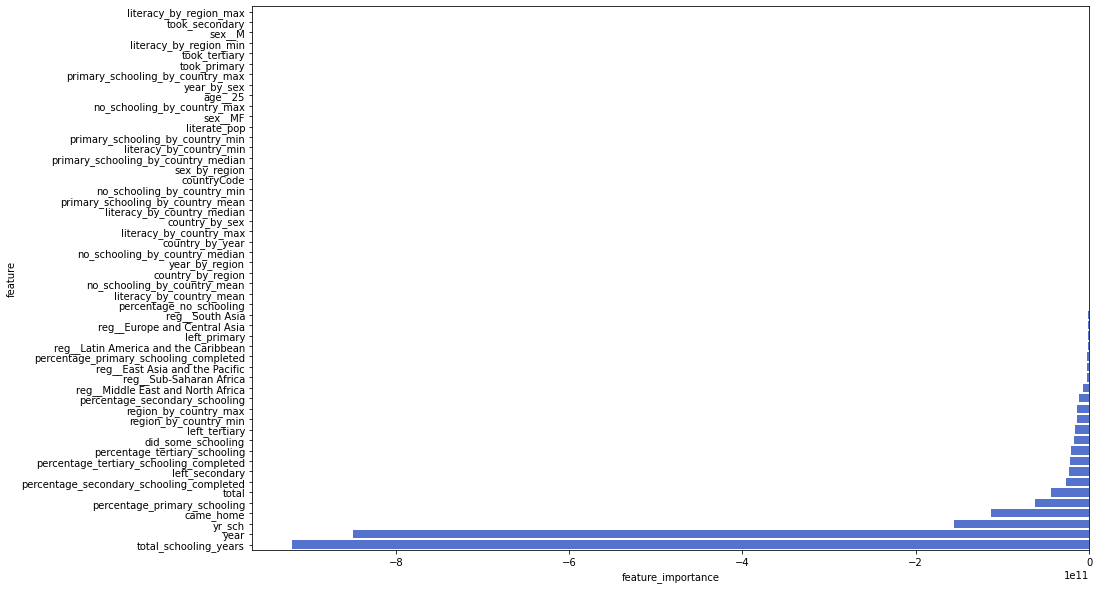

In [40]:
var_imp_plot(perm_imp_rfpimp)

In [ ]:
sub = pd.DataFrame()
sub['ID'] = ids
sub['Target'] = pred
sub.to_csv('xgb_guess2.csv', index= False)